In [ ]:
%tensorflow_version 1.x
!python -c "import tensorflow; print(tensorflow.__version__)"

TensorFlow 1.x selected.
1.15.2


In [ ]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

# Import Dataset

In [ ]:
%%shell
#!/bin/bash
DATASET_URL="http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz"
LOCAL_PATH="lfw-deepfunneled.tgz"
TARGET_CHECKSUM="68331da3eb755a505a502b5aacb3c201" # from http://vis-www.cs.umass.edu/lfw/#deepfunnel-anchor
wget $DATASET_URL
CHECKSUM=`md5sum lfw-deepfunneled.tgz | awk '{ print $1 }'`
if [ "$CHECKSUM" == $TARGET_CHECKSUM ]; then
    echo "Checksum correct."
    tar -zxf $LOCAL_PATH
    echo "Data extracted."
    rm $LOCAL_PATH
else
    echo "Checksum incorrect! Please retry."
    rm $LOCAL_PATH
fi

--2021-04-15 11:14:31--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘lfw-deepfunneled.tgz’

lfw-deepfunneled.tg 100%[===================>] 103.72M  15.0MB/s    in 8.3s    

2021-04-15 11:14:40 (12.5 MB/s) - ‘lfw-deepfunneled.tgz’ saved [108761145/108761145]

Checksum correct.
Data extracted.


In [ ]:
from pathlib import Path
import random

# set random seed for reproducibility
random.seed(42)

root = Path('lfw-deepfunneled')
all_people = sorted(root.iterdir())

train_directory = root / 'train'
train_directory.mkdir()
test_directory = root / 'test'
test_directory.mkdir()

# take some people with a reasonable number of images and put half in the test set.
# these people are then completely unknown - no corresponding training images
people = [person for person in all_people if len(list(person.iterdir())) == 3]
random.shuffle(people)
train_size = len(people) // 2

for person in people[:train_size]:
    person.rename(train_directory / person.name)

for person in people[train_size:]:
    person.rename(test_directory / person.name)

# for the rest of the people, find only those with at least 3 images and take one image from each to put in the test set
# these people are then already "known" - and so the task is re-identification
for person in set(all_people) - set(people):
    images = list(person.iterdir())

    if len(images) > 2:
        person_test_directory = test_directory / person.name
        person_test_directory.mkdir()
        images[0].rename(person_test_directory / images[0].name)

    person.rename(train_directory / person.name)

# Data Loading

In [ ]:
from itertools import chain

import tensorflow as tf


def generate_samples(n_samples, paths_per_person, sample_same=False):
    '''
    This will produce a list of image paths of length `n_samples`. These images
    will either all be of the same person or all of different people depending
    on the `sample_same` flag
    '''
    if sample_same:
        while True:
            # select person to sample
            person = random.choice(paths_per_person)

            # yield n_samples random samples of this person
            yield random.sample(person, n_samples)
    else:
        while True:
            # select n_samples random people
            people = random.sample(paths_per_person, n_samples)

            # yield one sample for each of these people
            yield [random.choice(person) for person in people]


def decode_image(path):
    '''Open a JPEG file from the given path and load as a `tensorflow.Tensor`'''
    return tf.image.convert_image_dtype(
        tf.image.decode_jpeg(tf.read_file(path), channels=3), tf.float32
    )


class PersonDataset:
    def __init__(self, root, n_per_sample, sample_same=False):
        '''
        Initialize a data loader that accesses a directory (`root`) containing sub-directories
        of images per-person. Each sample from the dataset will consist of `n_per_sample` images
        which are either all of the same person or all of different people depending on the
        `sample_same` flag
        '''
        self.root = Path(root)
        self.n_per_sample = n_per_sample
        self.sample_same = sample_same

        self.paths_per_person = [
            list(map(str, person_dir.glob("*.jpg"))) for person_dir in filter(Path.is_dir, self.root.iterdir())
        ]

    @property
    def tf_dataset(self):
        '''
        Provides a Tensorflow dataset:
            https://www.tensorflow.org/versions/r1.12/api_docs/python/tf/data/Dataset#class_dataset
        to enable easier loading of the data.
        '''
        def samples():
            return chain.from_iterable(generate_samples(self.n_per_sample, self.paths_per_person, self.sample_same))

        path_dataset = tf.data.Dataset.from_generator(samples, tf.string)

        return path_dataset.map(decode_image).batch(self.n_per_sample)


In [ ]:
dataset_root = Path('lfw-deepfunneled')
dataset_same = PersonDataset(dataset_root / 'train', n_per_sample=1, sample_same=True)

iterator = dataset_same.tf_dataset.batch(4).make_initializable_iterator()
data = iterator.get_next()

with tf.Session() as session:
    session.run(iterator.initializer)

    images = session.run(data)
    print(f"Images is a {images.dtype} tensor with shape {images.shape}")

Images is a float32 tensor with shape (4, 1, 250, 250, 3)


In [ ]:
data

<tf.Tensor 'IteratorGetNext:0' shape=(?, ?, ?, ?, 3) dtype=float32>

Visualization:




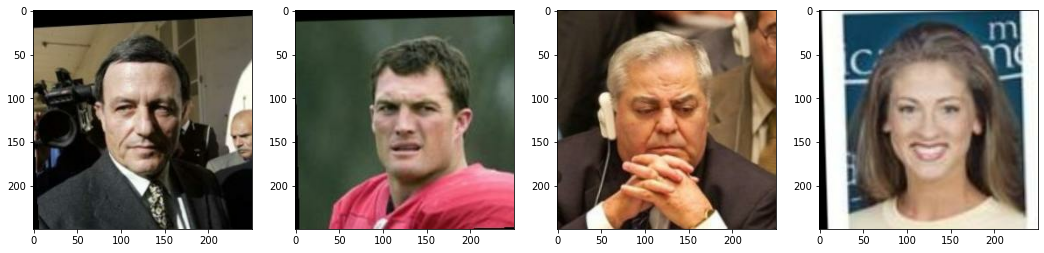

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(images), figsize=(18, 16))  # make the figure a bit big since the default is quite narrow

for ax, image in zip(axs, images[:, 0]):
    ax.imshow(image)

-------- STARTING POINT --------

# SETUP PHASE

In [ ]:
#import lib for pre-trained model
!pip install facenet-pytorch

In [ ]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import nn
import numpy as np

from facenet_pytorch import InceptionResnetV1

In [ ]:
root = Path('lfw-deepfunneled')
root

PosixPath('lfw-deepfunneled')

In [ ]:
class FaceTripletDataset(Dataset):
  ''' 
  Create a Dataset for face images as triplets: anchor - positive - negative
  '''
  def __init__(self, root_dir, transform = None):
    self.root_dir = root_dir
    self.transform = transform

    self.anchor_list = []
    self.positive_list = []
    self.negative_list = []
    single_samples = []

    # create list of single-image people
    for img_dir in os.listdir(root_dir):
      person_path = os.path.join(root_dir, img_dir)
      if len(os.listdir(person_path)) == 1:
        images = os.listdir(person_path)
        single_samples.append(os.path.join(person_path, images[0]))

    # create triplet lists
    for i, img_dir in enumerate(os.listdir(root_dir)):
      person_path = os.path.join(root_dir, img_dir)
      if len(os.listdir(person_path)) > 1:
        images = os.listdir(person_path)
        
        #create anchor - positive - negative lists
        #fix: pick random
        self.anchor_list.append(os.path.join(person_path, images[0]))
        self.positive_list.append(os.path.join(person_path, images[1]))
        #fix: pick random neg 
        self.negative_list.append(single_samples[cop])

  def __len__(self):
    return len(self.anchor_list)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    anchor = io.imread(anchor_list[idx])
    positive = io.imread(positive_list[idx])
    negative = io.imread(negative_list[idx])

    if self.transform:
      anchor = self.transform(anchor)
      positive = self.transform(positive)
      negative = self.transform(negative)
    
    sample = {
        'anchor': anchor,
        'positive': positive,
        'negative': negative
    }

    return sample

In [ ]:
def show_sample(sample):
  '''
  Show images of a triplet
  '''
  sample = np.array(sample)
  fig = plt.figure()

  plt.figure()

  f, ax = plt.subplots(1,3)
  plt.tight_layout()
  ax[0].imshow(np.array(sample['anchor'][0]))
  ax[1].imshow(np.array(sample['positive'][0]))
  ax[2].imshow(np.array(sample['negative'][0]))

  plt.show()

0 (250, 250, 3)
1 (250, 250, 3)
2 (250, 250, 3)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

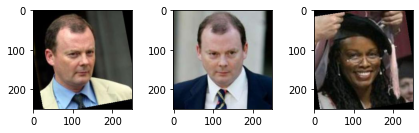

<Figure size 432x288 with 0 Axes>

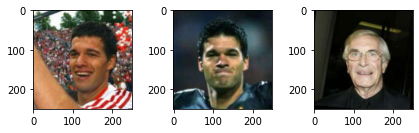

<Figure size 432x288 with 0 Axes>

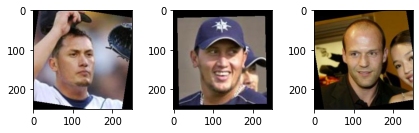

In [ ]:
# dataset working check
train_dataset = FaceTripletDataset(root.name + '/train/')
fig = plt.figure()
for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['anchor'].shape)

    plt.figure()

    f, ax = plt.subplots(1,3)
    plt.tight_layout()
    ax[0].imshow(sample['anchor'])
    ax[1].imshow(sample['positive'])
    ax[2].imshow(sample['negative'])

    if i == 2:
        plt.show()
        break

In [ ]:
# Dataset creation
train_dataset = FaceTripletDataset(root.name + '/train/',
                                           transform=transforms.Compose([
                                               transforms.ToTensor()
                                           ]))
# check dataset samples
for i in range(len(train_dataset)):
    sample = train_dataset[i]
    print(i, 
          sample['anchor'].size(), 
          sample['positive'].size(),
          sample['negative'].size())
    if i == 3:
        break

# Dataloader creation
dataloader = DataLoader(train_dataset, batch_size = 4, shuffle = True, num_workers = 4)


0 torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) torch.Size([3, 250, 250])
1 torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) torch.Size([3, 250, 250])
2 torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) torch.Size([3, 250, 250])
3 torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) torch.Size([3, 250, 250])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
device = 'cuda'

# create model - ResNet
model = InceptionResnetV1(pretrained='vggface2').eval()

feature_extracting = True

# freeze network parameters
def freeze_net(model):
  for param in model.parameters():
      param.requires_grad = False
  
freeze_net(model)

# change last layer - to be trained
model.last_linear = nn.Linear(in_features=1792, out_features=128, bias=False)
model.last_bn = nn.BatchNorm1d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)

model.to(device)


In [ ]:
# check parameters to learn
params_to_update = model.parameters()
print("Params to learn:")
if feature_extracting:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)

# Optimizer creation
optimizer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 last_linear.weight
	 last_bn.weight
	 last_bn.bias


In [ ]:
#util functions

def compute_dist(anchor, target):
  '''
  Compute distance of the embeddings
  '''
  soft = nn.Sigmoid()
  #print(torch.dist(anchor, target))
  dist = torch.dist(anchor, target)
  #prob = soft(torch.dist(anchor, target))
  #print(prob)
  return dist

def get_pred(anchor, target, thresh):
  '''
  Get prediction (same person) for the image pair: 1 - 0
  '''
  dist = compute_dist(anchor, target)

  if dist < thresh:
    return 1
  else: 
    return 0

def show_sample(anchor, positive, negative, anch_emb, pos_emb, neg_emb):
  '''
  Display triplet images for visualization and the distance with the anchor
  '''
  fig = plt.figure()

  plt.figure()

  f, ax = plt.subplots(1,3)
  plt.tight_layout()
  ax[0].imshow(np.array(anchor[0].permute(1, 2, 0)))
  ax[1].imshow(np.array(positive[0].permute(1, 2, 0)))
  ax[2].imshow(np.array(negative[0].permute(1, 2, 0)))

  plt.show()

  pos_score = compute_dist(anch_emb[0], pos_emb[0])
  neg_score = compute_dist(anch_emb[0], neg_emb[0])

  print('Positive distance: ' + str(pos_score))
  print('Negative distance: ' + str(neg_score))


# TRAINING PHASE

In [ ]:
def test(model):
  thresh = 0.8

  test_dataset = TrainDataset(root.name + '/test/', transform=transforms.Compose([
                                               transforms.ToTensor()
                                           ]))
  model_test = model.eval()

  # Dataloader
  dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = True, num_workers = 1)
  sample_num = len(test_dataset)
  true_pos = 0
  true_neg = 0
  false_pos = 0
  false_neg = 0
  display_step = 100
  cur_step = 0

  for n_batch, batch in enumerate(dataloader):
    b_size = len(batch['anchor'])
    anchor = batch['anchor'].to(device)
    positive = batch['positive'].to(device)
    negative = batch['negative'].to(device)

    anch_emb = model_test(anchor)
    pos_emb = model_test(positive)
    neg_emb = model_test(negative)

    pred_pos = get_pred(anch_emb.cpu(), pos_emb.cpu(), thresh)
    pred_neg = get_pred(anch_emb.cpu(), neg_emb.cpu(), thresh)

    if pred_pos == 1:
      true_pos += 1
    else:
      false_pos += 1

    if pred_neg == 0:
      true_neg += 1
    else:
      false_neg += 1 

    #visualize
    if cur_step % display_step == 0 and cur_step > 0:
      print('Predictions are: ' + str(pred_pos) + ' - ' + str(pred_neg))
      show_sample(anchor.cpu(), positive.cpu(), negative.cpu(), anch_emb.cpu(), pos_emb.cpu(), neg_emb.cpu())

    cur_step += 1

  accuracy = (true_pos + true_neg) / (sample_num * 2)
  precision = true_pos / (true_pos + false_pos)
  recall = true_pos / (true_pos + false_neg)

  print('True Positive: ' + str(true_pos) + ' / ' + str(sample_num))
  print('True Negative: ' + str(true_neg) + ' / ' + str(sample_num))
  print('False Positive: ' + str(false_pos) + ' / ' + str(sample_num))
  print('False Negative: ' + str(false_neg) + ' / ' + str(sample_num))
  print('Precision: ' + str(precision))
  print('Recall: ' + str(recall))
  print('Accuracy: ' + str(accuracy))

  return [accuracy, precision, recall]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Step 100: Loss: 0.3606923207640648
Predictions are: 1 - 0


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

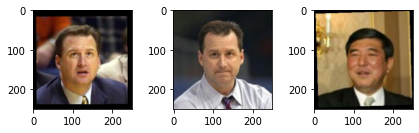

Positive distance: tensor(0.5911, grad_fn=<DistBackward>)
Negative distance: tensor(1.4726, grad_fn=<DistBackward>)
True Positive: 115 / 146
True Negative: 144 / 146
False Positive: 31 / 146
False Negative: 2 / 146
Precision: 0.7876712328767124
Recall: 0.9829059829059829
Accuracy: 0.886986301369863
Step 200: Loss: 0.29966608762741076
Predictions are: 1 - 0


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

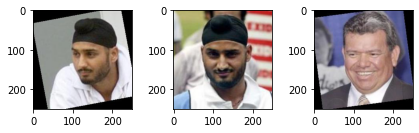

Positive distance: tensor(0.2709, grad_fn=<DistBackward>)
Negative distance: tensor(1.6910, grad_fn=<DistBackward>)
True Positive: 126 / 146
True Negative: 145 / 146
False Positive: 20 / 146
False Negative: 1 / 146
Precision: 0.863013698630137
Recall: 0.9921259842519685
Accuracy: 0.928082191780822
Step 300: Loss: 0.2582915323972701
Predictions are: 0 - 0


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

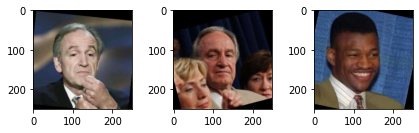

Positive distance: tensor(0.8935, grad_fn=<DistBackward>)
Negative distance: tensor(1.7374, grad_fn=<DistBackward>)
True Positive: 127 / 146
True Negative: 144 / 146
False Positive: 19 / 146
False Negative: 2 / 146
Precision: 0.8698630136986302
Recall: 0.9844961240310077
Accuracy: 0.928082191780822
Step 400: Loss: 0.23195612192153936
Predictions are: 1 - 0


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

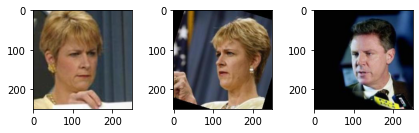

Positive distance: tensor(0.4289, grad_fn=<DistBackward>)
Negative distance: tensor(1.6848, grad_fn=<DistBackward>)
True Positive: 130 / 146
True Negative: 144 / 146
False Positive: 16 / 146
False Negative: 2 / 146
Precision: 0.8904109589041096
Recall: 0.9848484848484849
Accuracy: 0.9383561643835616
Step 500: Loss: 0.2026528866589069
Predictions are: 1 - 0


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

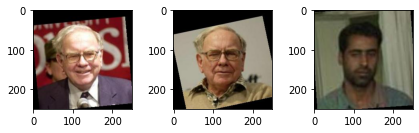

Positive distance: tensor(0.4607, grad_fn=<DistBackward>)
Negative distance: tensor(1.7508, grad_fn=<DistBackward>)
True Positive: 128 / 146
True Negative: 145 / 146
False Positive: 18 / 146
False Negative: 1 / 146
Precision: 0.8767123287671232
Recall: 0.9922480620155039
Accuracy: 0.934931506849315
Step 600: Loss: 0.19696427121758464
Predictions are: 0 - 0


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

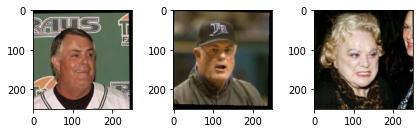

Positive distance: tensor(0.9791, grad_fn=<DistBackward>)
Negative distance: tensor(1.4837, grad_fn=<DistBackward>)
True Positive: 130 / 146
True Negative: 144 / 146
False Positive: 16 / 146
False Negative: 2 / 146
Precision: 0.8904109589041096
Recall: 0.9848484848484849
Accuracy: 0.9383561643835616
Step 700: Loss: 0.21296377807855607
Predictions are: 1 - 0


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

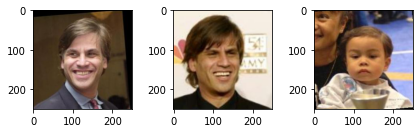

Positive distance: tensor(0.5895, grad_fn=<DistBackward>)
Negative distance: tensor(1.5320, grad_fn=<DistBackward>)
True Positive: 129 / 146
True Negative: 143 / 146
False Positive: 17 / 146
False Negative: 3 / 146
Precision: 0.8835616438356164
Recall: 0.9772727272727273
Accuracy: 0.9315068493150684
Step 800: Loss: 0.19588401168584835
Predictions are: 1 - 0


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

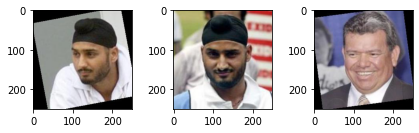

Positive distance: tensor(0.2496, grad_fn=<DistBackward>)
Negative distance: tensor(1.7477, grad_fn=<DistBackward>)
True Positive: 131 / 146
True Negative: 143 / 146
False Positive: 15 / 146
False Negative: 3 / 146
Precision: 0.8972602739726028
Recall: 0.9776119402985075
Accuracy: 0.9383561643835616
Step 900: Loss: 0.2009520903229714
Predictions are: 1 - 0


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

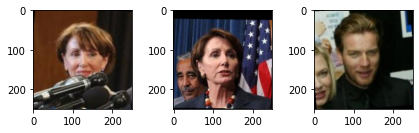

Positive distance: tensor(0.4980, grad_fn=<DistBackward>)
Negative distance: tensor(1.4351, grad_fn=<DistBackward>)
True Positive: 128 / 146
True Negative: 143 / 146
False Positive: 18 / 146
False Negative: 3 / 146
Precision: 0.8767123287671232
Recall: 0.9770992366412213
Accuracy: 0.928082191780822
Step 1000: Loss: 0.17531918659806242
Predictions are: 1 - 0


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

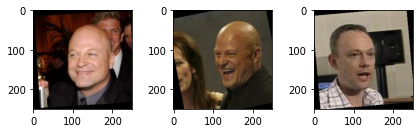

Positive distance: tensor(0.6335, grad_fn=<DistBackward>)
Negative distance: tensor(0.8267, grad_fn=<DistBackward>)
True Positive: 127 / 146
True Negative: 144 / 146
False Positive: 19 / 146
False Negative: 2 / 146
Precision: 0.8698630136986302
Recall: 0.9844961240310077
Accuracy: 0.928082191780822
Step 1100: Loss: 0.17069315597414972
Predictions are: 1 - 0


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

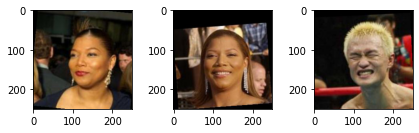

Positive distance: tensor(0.4081, grad_fn=<DistBackward>)
Negative distance: tensor(1.0906, grad_fn=<DistBackward>)
True Positive: 130 / 146
True Negative: 146 / 146
False Positive: 16 / 146
False Negative: 0 / 146
Precision: 0.8904109589041096
Recall: 1.0
Accuracy: 0.9452054794520548
Step 1200: Loss: 0.17434730425477024
Predictions are: 1 - 0


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

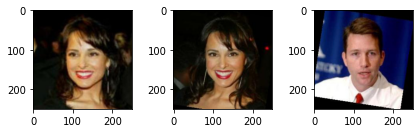

Positive distance: tensor(0.3600, grad_fn=<DistBackward>)
Negative distance: tensor(1.4722, grad_fn=<DistBackward>)
True Positive: 127 / 146
True Negative: 144 / 146
False Positive: 19 / 146
False Negative: 2 / 146
Precision: 0.8698630136986302
Recall: 0.9844961240310077
Accuracy: 0.928082191780822
Step 1300: Loss: 0.178560916185379
Predictions are: 1 - 0


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

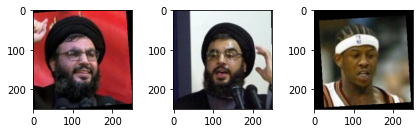

Positive distance: tensor(0.3678, grad_fn=<DistBackward>)
Negative distance: tensor(1.3001, grad_fn=<DistBackward>)
True Positive: 131 / 146
True Negative: 143 / 146
False Positive: 15 / 146
False Negative: 3 / 146
Precision: 0.8972602739726028
Recall: 0.9776119402985075
Accuracy: 0.9383561643835616
Step 1400: Loss: 0.17717903628945347
Predictions are: 1 - 0


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

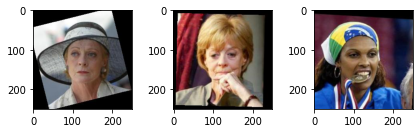

Positive distance: tensor(0.5942, grad_fn=<DistBackward>)
Negative distance: tensor(1.1944, grad_fn=<DistBackward>)
True Positive: 131 / 146
True Negative: 145 / 146
False Positive: 15 / 146
False Negative: 1 / 146
Precision: 0.8972602739726028
Recall: 0.9924242424242424
Accuracy: 0.9452054794520548


KeyboardInterrupt: ignored

In [ ]:
criterion = nn.TripletMarginLoss(margin=1.0, p=2)
n_epochs = 5
cur_step = 0
display_step = 100
mean_loss = 0
plot_loss = []
plot_acc = []
plot_prec = []
plot_rec = []

for epoch in range(n_epochs):
  for n_batch, batch in enumerate(dataloader):
    b_size = len(batch['anchor'])
    anchor = batch['anchor'].to(device)
    positive = batch['positive'].to(device)
    negative = batch['negative'].to(device)


    #zero grad
    optimizer.zero_grad()

    anch_emb = model(anchor)
    pos_emb = model(positive)
    neg_emb = model(negative)

    loss = criterion(anch_emb, pos_emb, neg_emb)
    loss.backward()

    optimizer.step()

    mean_loss += loss.item() / display_step

    #visualize
    if cur_step % display_step == 0 and cur_step > 0:
      print(f"Step {cur_step}: Loss: {mean_loss}")
      #show_sample(anchor.cpu(), positive.cpu(), negative.cpu(), anch_emb.cpu(), pos_emb.cpu(), neg_emb.cpu())

      #fix: save pth model

      acc, prec, rec = test(model)

      plot_loss.append(mean_loss)
      plot_acc.append(acc)
      plot_prec.append(prec)
      plot_rec.append(rec)
      mean_loss = 0

    cur_step += 1

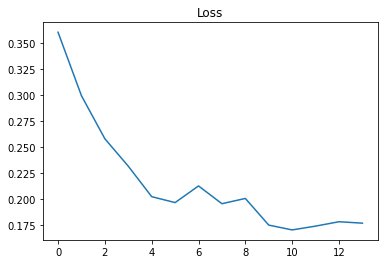

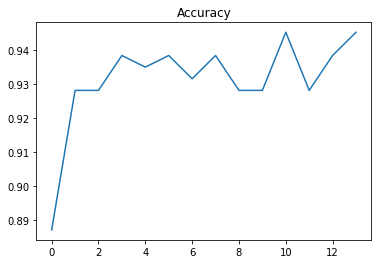

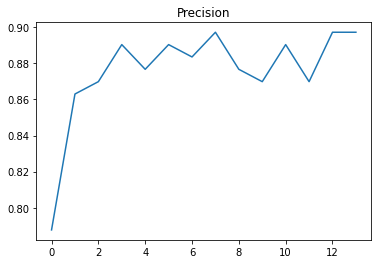

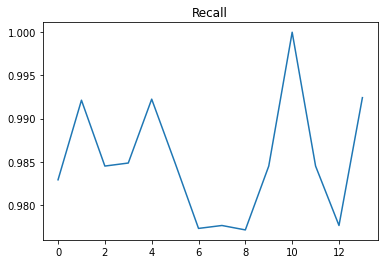

In [ ]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(plot_loss)
plt.show()

plt.title('Accuracy')
plt.plot(plot_acc)
plt.show()

plt.title('Precision')
plt.plot(plot_prec)
plt.show()

plt.title('Recall')
plt.plot(plot_rec)
plt.show()

# TEST PHASE

In [ ]:
test(model)